  This is a markdown document created in vscode with `.py` extension
 # Analyzing USCIS case status
 Disclaimer: I am not an attorny, and the information here is in no way supposed to provide legal advice.
 ## Background
 USCIS receives hundreds (i think) of applications daily and creates an ID for each application it receives called Reciept Number.
 The recipt number is an alphanumeric string of length 13 that starts with 3 letters (denoting the processing center) and 10 digits
 that are the combinations of fiscal year, computer work day, and serial number (according to the internet).
 I created a [module]('.\uscis') that takes in the receipt number and returns the heading of the status and the details.
 Then i further used the same module to gather about 4000 cases (before the server blocked my ip). The data is available in the [csv file]("uscis_status.csv")
 and has four columns
 - downloaded: computer time of downloading
 - receipt: recipt number from USCIS
 - heading: the heading of the case status
 - detail: detail of the case status
 In this project, I will read in data requested for egov.uscis.gov/casestatus.

In [1]:
# install python modules

# !pip install pandas
# !pip install matplotlib



In [2]:
#import python modules
import pandas as pd
import sqlite3
from matplotlib.pyplot import plot as plt
%matplotlib inline


In [3]:
#create sql connection object
con = sqlite3.connect("immigration.db")
df = pd.read_sql_query("select * from casestatus;", con)
print(df.shape)
print(df.head(5))
print(df.dtypes)


(4838, 4)
                 downloaded         recipt  \
0  Mon Jul 15 16:39:58 2019  MSC1891500000   
1  Mon Jul 15 16:39:59 2019  MSC1891500001   
2  Mon Jul 15 16:39:59 2019  MSC1891500002   
3  Mon Jul 15 16:40:00 2019  MSC1891500003   
4  Mon Jul 15 16:40:01 2019  MSC1891500004   

                                       heading  \
0  Card Was Delivered To Me By The Post Office   
1                        Card Was Mailed To Me   
2                            Case Was Approved   
3  Card Was Delivered To Me By The Post Office   
4  Card Was Delivered To Me By The Post Office   

                                              detail  
0  On November 17, 2018, the Post Office delivere...  
1  On January 16, 2019, we mailed your new card f...  
2  On November 13, 2018, we approved your Form I-...  
3  On November 19, 2018, the Post Office delivere...  
4  On December 8, 2018, the Post Office delivered...  
downloaded    object
recipt        object
heading       object
detail        objec

 After reading in the data and checking for data type, we need to see how the data is distributed.
 We draw a simple bar graph to understand what current status
 of most of the application are. To do that, we count the values of each item in heading and plot a
 bar graph

Card Was Delivered To Me By The Post Office                                       1548
Case Was Received                                                                  824
Case Closed Benefit Received By Other Means                                        364
Case Was Approved                                                                  360
Case Was Rejected Because It Was Improperly Filed                                  326
Case Rejected Because I Sent An Incorrect Fee                                      227
Card Was Mailed To Me                                                              158
Interview Was Scheduled                                                            131
Case is Ready to Be Scheduled for An Interview                                     122
Card Was Picked Up By The United States Postal Service                             119
Interview Was Completed And My Case Must Be Reviewed                               117
Decision Notice Mailed                     

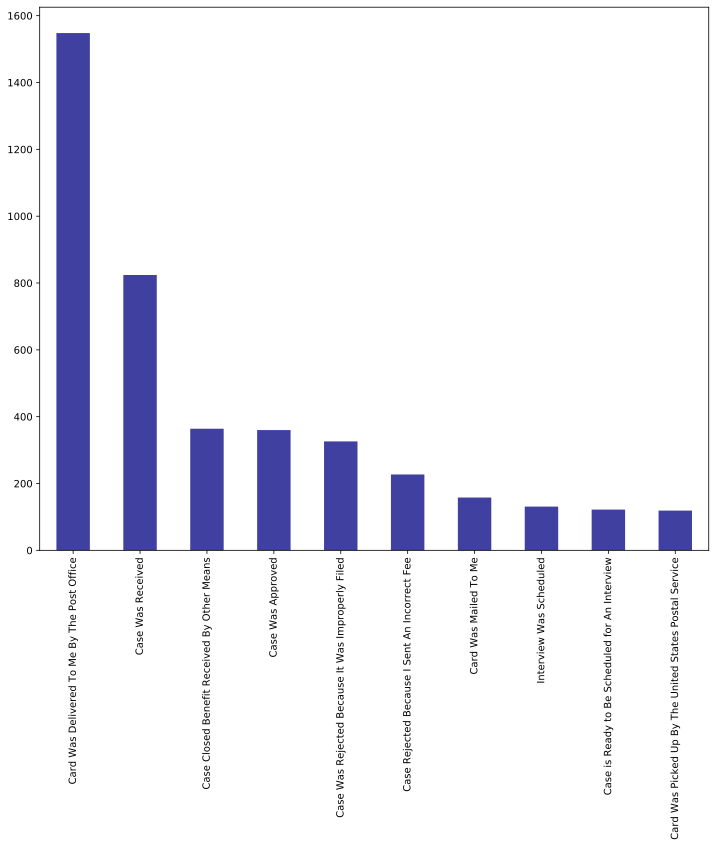

In [4]:
#looking at the distribution of headings
print(df['heading'].value_counts().sort_values(ascending=False))

barplot = df['heading'].value_counts().head(10).plot(kind='bar', 
            alpha=.75, figsize=(12,10), color='navy')


 As we can see that for a third of the application, the "card" was delivered
 (which means the application was approved) and for a sixth, the case was received (they received the application)
 As we can see the useful information are in the `detail` column. It has last activity date,
 what the deicsion is, etc. We could probably try to get information from the text values. We will need to do some
 text processing/feature engieering to get the data that we are interested in. Part of the text i am interested in are:
 - Last date the application status was updated (usually for sentence)
 - The form number for the receipt (tells what kind of application it was)
 - Decision (maybe)

In [5]:
df['last_opened'] = df['detail'].str.extract(r"(\w+ \d{1,2}, \d{4})",0)
df['form'] = df['detail'].str.extract(r"(\w-\d{1,3})",0)



 more plots

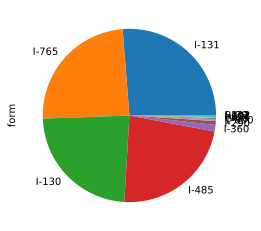

In [6]:
pie= df['form'].dropna().value_counts().plot(kind='pie')



 We can see that the four forms I-130, I-131, I-485, and I-765 are in almost equal proportion.
 It makes sense that those four fomrs are in equal proportions since USCIS National Benefits center,
 where receipt numbers start with MSC, receives permanent resicency applications along with petition for relative.
 Usually, each petitioner files all these forms together
 In addition there are other forms which are in very small proportions as well. Which aren't very informative.
 The employment authorization documents and Advance Parole Documents usually get approved within a few months wherease
 the change of status and forein relative petition takes longer. We can see t
 Close inspection of the form counts and their statuses

In [7]:
df[df['form'].isin(['I-130', 'I-131', 'I-485', 'I-765'])].groupby(['form','heading'])['recipt'].count()




form   heading                                                                  
I-130  Case Closed Benefit Received By Other Means                                    1
       Case Rejected Because I Sent An Incorrect Fee                                 27
       Case Rejected For Incorrect Fee And Form Not Signed                            1
       Case Was Approved                                                            144
       Case Was Received                                                            392
                                                                                   ... 
I-765  Fingerprint Review Was Completed                                              16
       Name Was Updated                                                               1
       Notice Was Returned To USCIS Because The Post Office Could Not Deliver It      4
       Request for Initial Evidence Was Sent                                          2
       Response To USCIS' Request For E

 checking the status of form I-485 can explain how the cases are moving.
 Another way to think about it is that every unique person can be identified
 by their I-485 number. Once their i-485 is completed/closed, their case is closed

In [8]:
greencard = df[df['form']=='I-485']
print(greencard.head())


                  downloaded         recipt  \
1   Mon Jul 15 16:39:59 2019  MSC1891500001   
5   Mon Jul 15 16:40:01 2019  MSC1891500005   
14  Mon Jul 15 16:40:06 2019  MSC1891500014   
15  Mon Jul 15 16:40:06 2019  MSC1891500015   
16  Mon Jul 15 16:40:07 2019  MSC1891500016   

                                              heading  \
1                               Card Was Mailed To Me   
5   Case Was Rejected Because It Was Improperly Filed   
14  Correspondence Was Received And USCIS Is Revie...   
15  Correspondence Was Received And USCIS Is Revie...   
16  Correspondence Was Received And USCIS Is Revie...   

                                               detail       last_opened   form  
1   On January 16, 2019, we mailed your new card f...  January 16, 2019  I-485  
5   On August 3, 2018, we rejected your Form I-485...    August 3, 2018  I-485  
14  On April 2, 2019, we received your corresponde...     April 2, 2019  I-485  
15  On April 2, 2019, we received your corresponde

In [9]:
import datetime
print(datetime.datetime.now() -df.to_datetime(['last_opened'],format='%B %d, %Y'))
# print(datetime.date.today()- datetime.strptime('February 1, 2019', '%B %d %Y'))



AttributeError: 'DataFrame' object has no attribute 'to_datetime'